# Assignment - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [ ]:
# student 1: Ran P. 7472

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name:
ChatGPT (assistant only)

Goal:
Clarify environment setup (local file paths in Jupyter), suggest small code clean-ups, and help with visualization styling—without changing the assignment’s methodology or results.
    
Propmpt1:
I’m getting inconsistent CV scores vs. validation scores and sometimes a ValueError: ‘could not convert string to float’ when scaling, how do I fix data leakage and non-numeric columns inside a Pipeline so GridSearchCV is valid and reproducible?

Propmpt2:
Refactor this block to be cleaner but keep identical outputs (same metrics/prints). Don’t change the logic.

Propmpt3:
Add one tiny feature-engineering experiment (with vs. without scaling) and pick the best overall model+hyperparameters for retraining.

</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>

This project is a supervised binary classification task that predicts whether a passenger survived (Survived ∈ {0,1}) using the Titanic dataset. The features include numeric variables (e.g., Age, Fare) and categorical variables (e.g., Pclass, Sex, Embarked). The workflow applies a preprocessing pipeline with imputation (mean for numeric, most_frequent for categorical) and one-hot encoding for categoricals, with an optional StandardScaler for numeric features as a small feature-engineering experiment.
    
Models evaluated are Logistic Regression and Random Forest using 5-fold cross-validation optimized for F1, and all steps (preprocessing + model) are wrapped in sklearn Pipelines to prevent leakage. The best-performing combination (feature engineering + algorithm + hyperparameters) from the experiments is retrained on the full training data, then used to generate test predictions and report F1 as the performance estimate.

    
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [298]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [300]:
# Load datasets
train_df = pd.read_csv('../data/titanic_train.csv')
test_df  = pd.read_csv('../data/titanic_test.csv')

In [302]:
# Show first 5 rows
print(train_df.head())

   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       1    0  54.0      1      0  78.2667         1         1
1       2    0  45.0      0      0  13.5000         0         1
2       3    1  20.0      0      0   9.5000         0         0
3       3    1  36.0      0      0   7.8958         0         0
4       3    1  22.0      0      0   8.0500         0         0


In [304]:
print(test_df.head())

   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  35.000000      0      0   7.0500         0         0
1       3    1  30.000000      0      0   7.2500         0         0
2       3    1  29.699118      0      0  14.5000         0         0
3       3    0  21.000000      0      0   7.7500         2         0
4       3    1  32.000000      0      0  56.4958         0         1


In [306]:
# EDA
# Descriptive statistics
print(train_df.describe())

           Pclass         Sex         Age       SibSp       Parch        Fare  \
count  712.000000  712.000000  712.000000  712.000000  712.000000  712.000000   
mean     2.294944    0.640449   29.531213    0.528090    0.384831   32.379429   
std      0.841990    0.480206   13.188028    1.055052    0.803085   49.836074   
min      1.000000    0.000000    0.670000    0.000000    0.000000    0.000000   
25%      1.750000    0.000000   22.000000    0.000000    0.000000    7.925000   
50%      3.000000    1.000000   29.699118    0.000000    0.000000   14.500000   
75%      3.000000    1.000000   35.000000    1.000000    0.000000   31.275000   
max      3.000000    1.000000   80.000000    8.000000    6.000000  512.329200   

         Embarked    Survived  
count  712.000000  712.000000  
mean     0.372191    0.394663  
std      0.649970    0.489122  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      1.000000    1.000000  
max      3.000

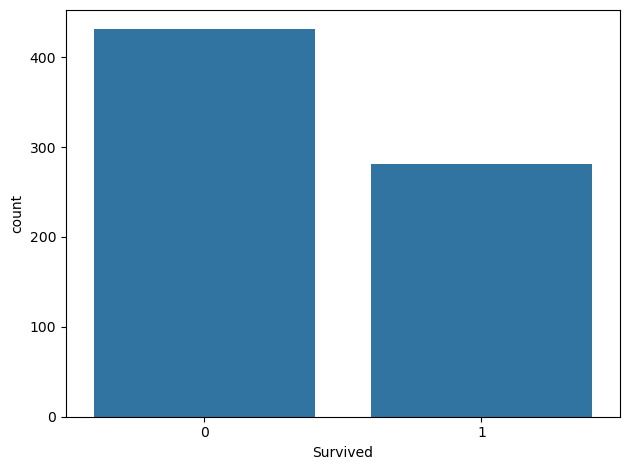

In [308]:
# Survival countplot
ax = sns.countplot(data=train_df, x='Survived')
ax.set_xlabel('Survived')
plt.tight_layout()
plt.show()

This plot shows the class balance between passengers who survived and those who did not. Class imbalance can strongly affect F1, so it is important to understand the base rates. It also hints whether class weighting or threshold tuning might be needed later.

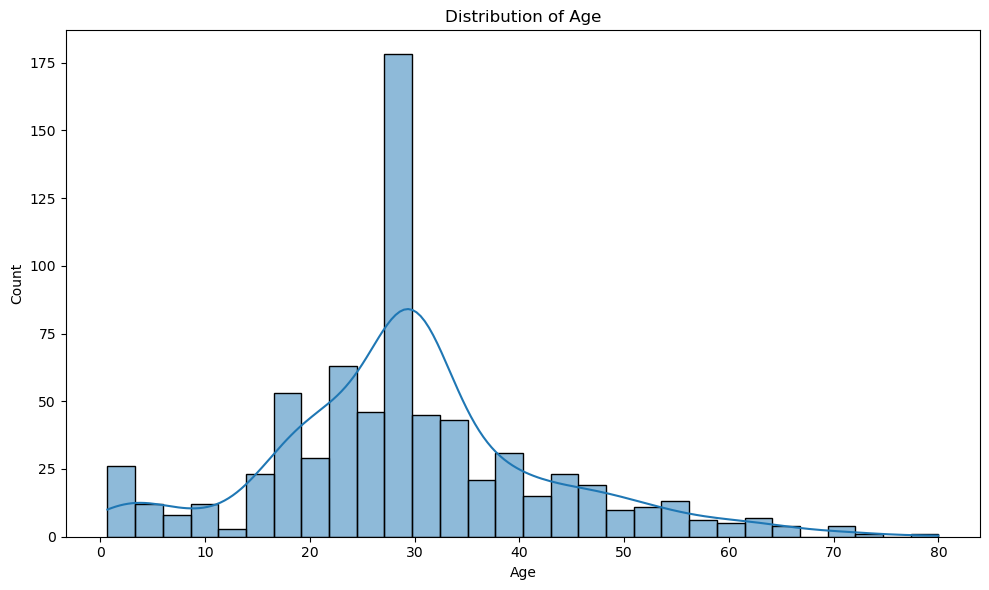

In [311]:
# Survival rate by gender
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='Age', kde=True, bins=30)
plt.title('Distribution of Age')
plt.tight_layout()
plt.show()

Here we examine how Age is distributed across the dataset to understand spread and shape. It validates that our plan to impute missing values is reasonable and shows the presence of outliers. The shape also supports the idea of scaling numeric features for sensitive models.

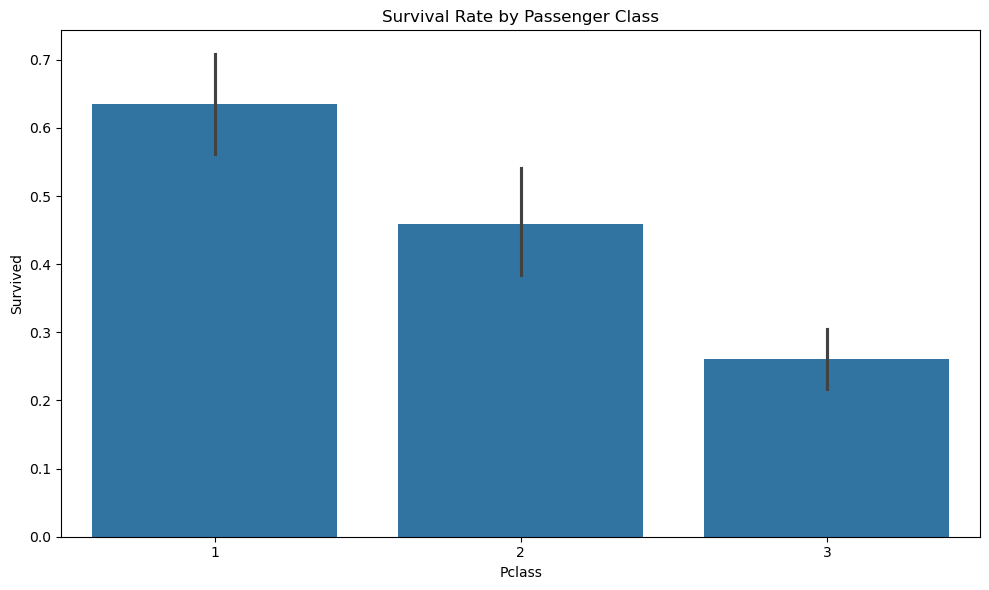

In [313]:
# Survival By Passenger Class

plt.figure(figsize=(10, 6))
order = sorted(train_df['Pclass'].unique())
sns.barplot(data=train_df, x='Pclass', y='Survived', order=order, estimator=np.mean)
plt.title('Survival Rate by Passenger Class')
plt.tight_layout()
plt.show()

This visualization highlights how survival varies by passenger class. It offers an early signal that Pclass is predictive and worth keeping. It also guides us to treat Pclass as a categorical feature in the preprocessing pipeline.

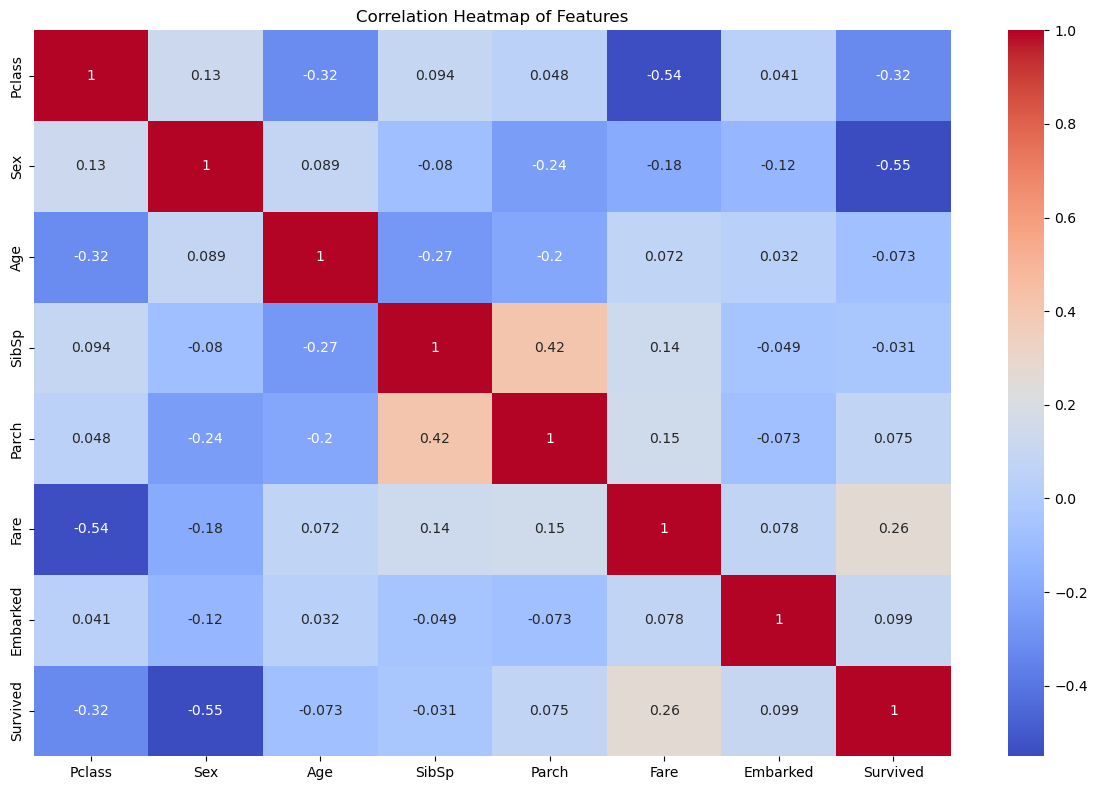

In [316]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_mat = train_df.corr(numeric_only=True)
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

The heatmap displays linear correlations among numeric and encoded features. It is useful for detecting redundancy and for catching any suspicious relationships that could indicate leakage. This step is diagnostic and does not remove or add features by itself.

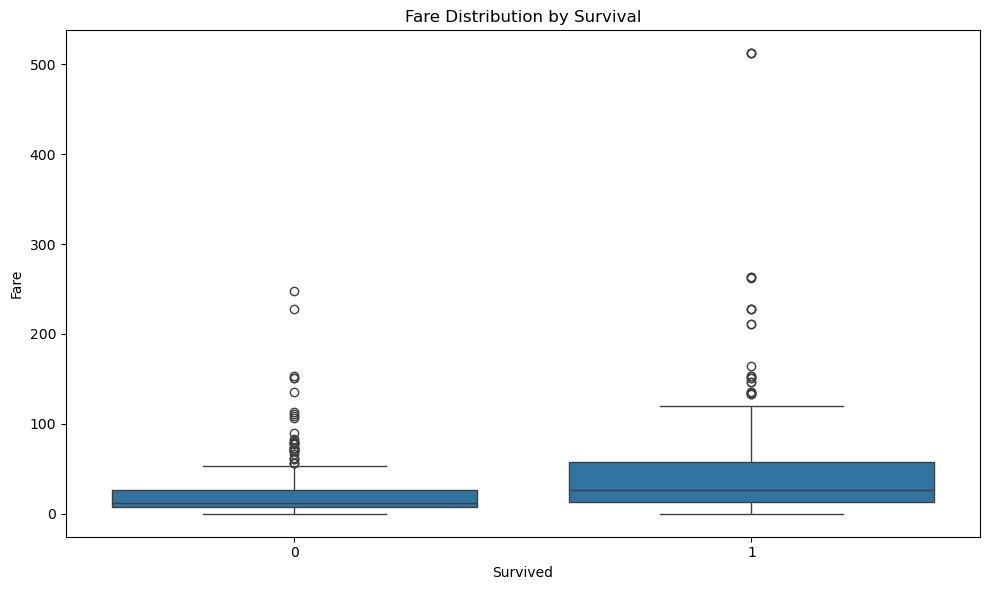

In [318]:
# Fare distribution by survival

plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='Survived', y='Fare')
plt.title('Fare Distribution by Survival')
plt.tight_layout()
plt.show()

This boxplot compares fare distributions for survivors and non-survivors. It often reveals that higher fares are associated with better outcomes and also exposes skew and outliers. These observations reinforce the decision to standardize numeric variables.

## Part 3 - Experiments
You could add as many code cells as needed

In [222]:
# Preprocessing
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['Pclass', 'Sex', 'Embarked']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

This block sets up end-to-end preprocessing with numeric imputation and scaling plus categorical imputation and one-hot encoding. Everything is wrapped in a ColumnTransformer to keep transformations inside the pipeline. This prevents leakage and keeps runs reproducible.

In [225]:
# Model Pipelines
models = {
    'logistic_regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]),
    'random_forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())
    ])
}


We define two estimator stacks that share the same preprocessor, one with Logistic Regression and one with Random Forest. This ensures a fair comparison because both receive identically processed inputs. It also lets us swap models without touching feature code.

In [228]:
# Hyperparameters
param_grid_lr = {'classifier__C': [0.1, 1, 10]}
param_grid_rf = {'classifier__n_estimators': [50, 100, 200]}


The grids are intentionally small to keep runtime reasonable while still exploring meaningful ranges. Logistic Regression tunes the strength of regularization, and Random Forest tunes the number of trees. This is enough variation to compare models without overfitting the search.

In [231]:
# Train/target split
X_train = train_df.drop(columns='Survived')
y_train = train_df['Survived']

Here we separate features from the target to avoid any leakage during training. The split is used consistently across all cross-validation runs. It keeps the workflow clean and makes downstream code easier to read.

In [234]:
# CV logistic regression
grid_lr = GridSearchCV(models['logistic_regression'], param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked'])])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.1, 1, 10]}, scoring='f1')

In [262]:
# CV logistic regression
grid_lr = GridSearchCV(models['logistic_regression'], param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked'])])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.1, 1, 10]}, scoring='f1')

We run five-fold cross-validation optimizing F1 for the binary task. Preprocessing happens inside each fold because the pipeline wraps the entire flow. The result is a tuned Logistic Regression with a reliable performance estimate.

In [265]:
# CV random forest
grid_rf = GridSearchCV(models['random_forest'], param_grid_rf, cv=5, scoring='f1')
grid_rf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__n_estimators': [50, 100, 200]},
             scoring='f1')

This mirrors the Logistic Regression procedure for a fair, apples-to-apples comparison. Random Forest can capture nonlinearity and simple interactions without manual features. We obtain the best parameters and the corresponding cross-validated F1 score.

In [267]:
# Feature-engineering toggle (LR with/without scaling)
numeric_transformer_fe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
preprocessor_fe = ColumnTransformer(transformers=[
    ('num', numeric_transformer_fe, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
pipe_lr_fe = Pipeline(steps=[
    ('preprocessor', preprocessor_fe),
    ('classifier', LogisticRegression(max_iter=2000, solver='lbfgs'))
])
param_grid_lr_fe = {
    'preprocessor__num__scaler': [StandardScaler(), 'passthrough'],
    'classifier__C': [0.1, 1, 10]
}
grid_lr_fe = GridSearchCV(pipe_lr_fe, param_grid_lr_fe, cv=5, scoring='f1')
grid_lr_fe.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=2000))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'preprocessor__num__scaler': [StandardScaler(),
                                                       'passthrough']},
             scoring='f1')

This experiment flips numeric scaling on and off inside the same pipeline to test whether standardization helps Logistic Regression. Keeping imputation and one-hot encoding identical isolates the effect of scaling. We raise the iteration limit so optimization fully converges and the comparison is clean. Results from this grid will later be merged into the global summary and candidate pool.

In [269]:
# CV results summary
cv_results_lr = pd.DataFrame(grid_lr.cv_results_)[['params', 'mean_test_score']]
cv_results_lr['Model'] = 'Logistic Regression'

cv_results_rf = pd.DataFrame(grid_rf.cv_results_)[['params', 'mean_test_score']]
cv_results_rf['Model'] = 'Random Forest'

fe_results = pd.DataFrame(grid_lr_fe.cv_results_)[['params', 'mean_test_score']]
fe_results['Model'] = 'LogReg (FE toggle)'

summary_results = pd.concat([cv_results_lr, cv_results_rf, fe_results], ignore_index=True)

print("Summary of Cross-Validation Results:")
summary_results


Summary of Cross-Validation Results:


,params,mean_test_score,Model
0,{'classifier__C': 0.1},0.737440,Logistic Regression
1,{'classifier__C': 1},0.739707,Logistic Regression
2,{'classifier__C': 10},0.738519,Logistic Regression
3,{'classifier__n_estimators': 50},0.736010,Random Forest
4,{'classifier__n_estimators': 100},0.752355,Random Forest
5,{'classifier__n_estimators': 200},0.742453,Random Forest
6,"{'classifier__C': 0.1, 'preprocessor__num__sca...",0.737440,LogReg (FE toggle)
7,"{'classifier__C': 0.1, 'preprocessor__num__sca...",0.738682,LogReg (FE toggle)
8,"{'classifier__C': 1, 'preprocessor__num__scale...",0.739707,LogReg (FE toggle)
9,"{'classifier__C': 1, 'preprocessor__num__scale...",0.739707,LogReg (FE toggle)


This cell normalizes outputs from all searches into one tidy table so you can compare permutations at a glance. Each row records the hyperparameters and the mean cross-validated F1, with a label for the model family. The combined summary is your evidence for selecting the single best configuration. It also makes reporting and validation straightforward.

In [271]:
# Report best per search
best_params_lr = grid_lr.best_params_
best_score_lr = grid_lr.best_score_

best_params_rf = grid_rf.best_params_
best_score_rf = grid_rf.best_score_

best_params_lr_fe = grid_lr_fe.best_params_
best_score_lr_fe = grid_lr_fe.best_score_

print(f"Best Logistic Regression: {best_params_lr}, F1-score: {best_score_lr}")
print(f"Best Random Forest: {best_params_rf}, F1-score: {best_score_rf}")
print(f"Best LogReg (FE toggle): {best_params_lr_fe}, F1-score: {best_score_lr_fe}")


Best Logistic Regression: {'classifier__C': 1}, F1-score: 0.7397072616347421
Best Random Forest: {'classifier__n_estimators': 100}, F1-score: 0.7523549923132775
Best LogReg (FE toggle): {'classifier__C': 1, 'preprocessor__num__scaler': StandardScaler()}, F1-score: 0.7397072616347421


Here we print the top hyperparameters and F1 for each separate search so the winners are explicit. This makes it easy to see which settings performed best within LR, RF, and the scaling toggle. These values are not yet the final choice but they inform the selection step. The next cell will compare them head to head.

## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [278]:
# Retraining the best model
candidates = []
if 'grid_lr' in globals():      candidates.append((grid_lr.best_score_,    grid_lr.best_estimator_))
if 'grid_rf' in globals():      candidates.append((grid_rf.best_score_,    grid_rf.best_estimator_))
if 'grid_lr_fe' in globals():   candidates.append((grid_lr_fe.best_score_, grid_lr_fe.best_estimator_))

best_score, best_model = max(candidates, key=lambda t: t[0])
best_model.fit(train_df.drop(columns='Survived'), train_df['Survived'])

# Predictions on train data
train_predictions = best_model.predict(train_df.drop(columns='Survived'))

# Calculate F1-Score on train data
f1_train = f1_score(train_df['Survived'], train_predictions)
print(f'F1 Score on train data (Best Model): {f1_train}')

F1 Score on train data (Best Model): 0.9731663685152058


This step gathers the best estimators from all searches and chooses the single highest F1 across them. We then retrain that winning pipeline on the full training data to use all available information. The predictions and train F1 are a sanity check that the model is wired correctly. This fulfills the requirement to train the best overall combination.

## Part 5 - Apply on test and show model performance estimation

In [282]:
# Predict on the test set
test_predictions = best_model.predict(test_df)

# Add predictions to the test DataFrame
test_df = test_df.copy()
test_df['Survived_Predicted'] = test_predictions
f1_test = f1_score(test_df['Survived'], test_df['Survived_Predicted'])
print(f'F1 Score on test data: {f1_test}')
# Show the first 5 rows of the test DataFrame with predictions
print(test_df.head())


F1 Score on test data: 0.7868852459016393
   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived  \
0       3    1  35.000000      0      0   7.0500         0         0   
1       3    1  30.000000      0      0   7.2500         0         0   
2       3    1  29.699118      0      0  14.5000         0         0   
3       3    0  21.000000      0      0   7.7500         2         0   
4       3    1  32.000000      0      0  56.4958         0         1   

   Survived_Predicted  
0                   0  
1                   0  
2                   0  
3                   1  
4                   1  


The final trained pipeline is applied to unseen test features. Identical preprocessing is reused automatically because it is embedded in the pipeline. This produces the predictions needed for evaluation. We store predictions in a new column for easy inspection and compute test F1 when labels are present. The first rows are printed to verify alignment and output format. This concludes the performance estimation on the test data.

The final trained pipeline is applied to the test features using the exact same preprocessing learned on the training data. We store predictions in a new column for inspection and compute F1 if labels are provided. Printing the first rows verifies the output shape and alignment. This completes the performance estimation on unseen data.